In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from d2d import *
from compile_fit import *


filename = "/data/fast0/datasets/Rhone_data_continuous.h5"
f = h5py.File(filename, 'r')
print("Keys: %s" % f.keys())

Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>


In [2]:
das_data_all = f['DAS Data'][:]
discharge = f['Discharge'][:]

df_all_chan = pd.DataFrame(das_data_all)
df_all_chan['Discharge'] = discharge
df_all_chan.head()

,0,1,2,3,4,5,6,7,8,9,...,2487,2488,2489,2490,2491,2492,2493,2494,2495,Discharge
0,1737.318436,1932.321258,1788.269101,3706.977556,1831.756626,1768.674227,1908.850695,3690.341997,1804.145150,2437.436803,...,3603.932847,2066.070800,2215.669390,1881.772352,3990.883595,1584.965970,1787.281257,1862.912440,4160.545583,9.947179
1,8161.349279,8245.783723,8118.189935,528.834231,468.890511,714.714310,728.051775,158.440806,82.719811,116.949415,...,8238.452283,8204.901437,8194.671705,8228.769841,8211.066134,8229.370787,8218.436955,8210.143402,8178.032001,9.934657
2,8242.942236,8205.640252,8093.980026,510.832905,451.884623,709.510655,709.932307,153.715844,83.404382,116.112236,...,8184.500407,8221.490571,8202.429647,8194.927561,8197.675324,8188.718827,8189.658071,8225.017259,8163.918322,9.929290
3,8159.780047,8196.654224,8113.873839,489.734947,438.657688,690.418208,701.896139,158.058233,83.003254,112.787627,...,8173.860868,8156.187127,8151.113841,8235.843141,8145.360321,8192.392266,8169.275389,8129.926491,8161.652382,9.923923
4,8198.498465,8161.470921,8120.452338,521.425978,444.272741,689.710217,695.164917,160.246640,84.054029,111.125592,...,8198.827286,8234.815465,8219.987333,8140.961605,8193.517740,8157.154485,8241.648596,8229.194191,8234.212679,9.918557


In [3]:
# Split the data
column_indices = {name: i for i, name in enumerate(df_all_chan.columns)}
n = len(df_all_chan)

train_df = df_all_chan[int(n*0.3):int(n*1.0)]
val_df = df_all_chan[int(n*0.0):int(n*0.2)]
test_df = df_all_chan[int(n*0.2):int(n*0.3)]

In [4]:
input_columns = list(np.arange(0,2308,1))

In [5]:
# Normalize
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [6]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=0,
    train_df=train_df, 
    val_df=val_df, 
    test_df=test_df,
    label_columns=['Discharge'],
    input_columns=input_columns)

# Defining the models

In [7]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

dnn_model = tf.keras.models.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
])

In [8]:
history = compile_and_fit(linear, single_step_window)

val_performance={}
performance={}
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1373/1373 [==============================] - 9s 6ms/step - loss: 0.4847 - mean_absolute_error: 0.4669 - val_loss: 0.7699 - val_mean_absolute_error: 0.7419
Epoch 2/20
1373/1373 [==============================] - 9s 6ms/step - loss: 0.4748 - mean_absolute_error: 0.4153 - val_loss: 3.6228 - val_mean_absolute_error: 1.6627
Epoch 3/20
393/393 [==============================] - 7s 570us/step - loss: 1.4831 - mean_absolute_error: 1.0235


## Examine the linear model weights

5


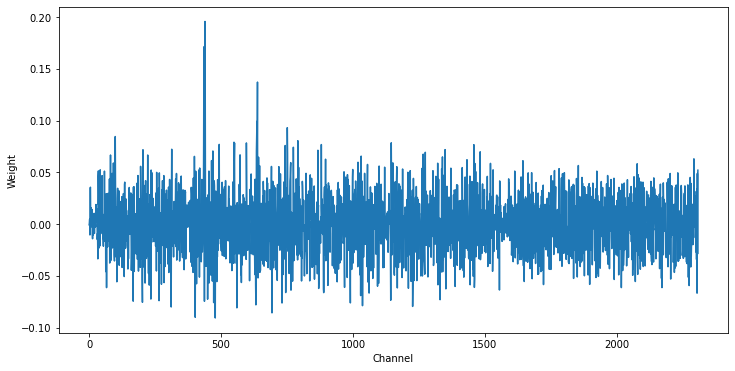

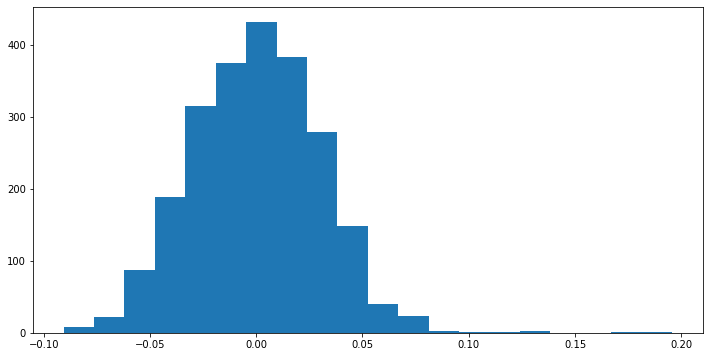

In [32]:
weights = linear.layers[0].kernel[:,0].numpy()

plt.subplots(figsize=(12,6))
plt.plot(weights)
plt.xlabel('Channel')
plt.ylabel('Weight')

plt.subplots(figsize=(12,6))
plt.hist(weights,20)
# plt.yscale('log')

print(np.sum(weights>0.1))

In [176]:
multi_step_window = WindowGenerator(
    input_width=200, label_width=1, shift=0,
    train_df=train_df, 
    val_df=val_df, 
    test_df=test_df,
    label_columns=['Discharge'],
    input_columns=input_columns)

# Multistep Model Runs

# Retraining same model on different partitions of training, val, and test

### Can I create a for loop to do this?

In [180]:
n = 10000  #chunk row size
list_df = [df_all_chan[i:i+n] for i in range(0,df_all_chan.shape[0],n)] #list_df is a list of partitions 
list_df[0]

,0,1,2,3,4,5,6,7,8,9,...,2487,2488,2489,2490,2491,2492,2493,2494,2495,Discharge
0,1737.318436,1932.321258,1788.269101,3706.977556,1831.756626,1768.674227,1908.850695,3690.341997,1804.145150,2437.436803,...,3603.932847,2066.070800,2215.669390,1881.772352,3990.883595,1584.965970,1787.281257,1862.912440,4160.545583,9.947179
1,8161.349279,8245.783723,8118.189935,528.834231,468.890511,714.714310,728.051775,158.440806,82.719811,116.949415,...,8238.452283,8204.901437,8194.671705,8228.769841,8211.066134,8229.370787,8218.436955,8210.143402,8178.032001,9.934657
2,8242.942236,8205.640252,8093.980026,510.832905,451.884623,709.510655,709.932307,153.715844,83.404382,116.112236,...,8184.500407,8221.490571,8202.429647,8194.927561,8197.675324,8188.718827,8189.658071,8225.017259,8163.918322,9.929290
3,8159.780047,8196.654224,8113.873839,489.734947,438.657688,690.418208,701.896139,158.058233,83.003254,112.787627,...,8173.860868,8156.187127,8151.113841,8235.843141,8145.360321,8192.392266,8169.275389,8129.926491,8161.652382,9.923923
4,8198.498465,8161.470921,8120.452338,521.425978,444.272741,689.710217,695.164917,160.246640,84.054029,111.125592,...,8198.827286,8234.815465,8219.987333,8140.961605,8193.517740,8157.154485,8241.648596,8229.194191,8234.212679,9.918557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8216.136264,8341.752852,8240.940177,646.662313,521.615071,687.289448,496.409176,170.853606,118.160048,121.487678,...,8231.697103,8260.884095,8252.189323,8214.393657,8249.569663,8267.274630,8235.091427,8262.757726,8266.493848,5.450400
9996,8299.125644,8343.262260,8271.665761,633.745447,496.616703,671.251222,436.118079,180.486280,141.182780,109.466751,...,8257.331263,8243.016406,8315.547470,8330.524710,8278.497412,8282.190912,8288.338669,8231.309952,8300.629228,5.452200
9997,8226.304473,8211.995563,8214.226577,658.793542,490.893919,691.924094,489.356272,179.542433,169.462663,87.622215,...,8261.160411,8258.612412,8236.682803,8241.355549,8253.403740,8233.463012,8217.282709,8293.313696,8279.108940,5.454000
9998,8291.540311,8340.032374,8272.550011,685.838140,492.012415,669.942546,394.220818,207.499712,202.700682,101.572003,...,8227.621614,8260.764062,8322.770561,8263.860537,8309.207158,8301.337959,8313.773173,8264.281224,8241.038434,5.455800


In [181]:
val_performance={}
performance={}

In [ ]:
k = 1

for i in list_df:
    n = len(i)
    labels = list(i.index)
    
    df_all_chan_copy = df_all_chan.copy()
    
    train_df = df_all_chan_copy.drop(labels=labels, axis=0) # drop the portion that is partitioned to be used for val, test
    
    val_df = i[int(n*0.0):int(n*0.6)]
    test_df = i[int(n*0.6):int(n*1.0)]
    
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    history = compile_and_fit(linear, multi_step_window)

    val_performance['Multistep_Linear_fold' + str(k)] = linear.evaluate(multi_step_window.val)
    performance['Multistep_Linear_fold' + str(k)] = linear.evaluate(multi_step_window.test, verbose=0)
    
    history = compile_and_fit(dnn_model, multi_step_window)

    val_performance['Multistep_DNN_fold' + str(k)] = dnn_model.evaluate(multi_step_window.val)
    performance['Multistep_DNN_fold' + str(k)] = dnn_model.evaluate(multi_step_window.test, verbose=0)
    
    history = compile_and_fit(lstm_model, multi_step_window)

    val_performance['Multistep_LSTM_fold' + str(k)] = lstm_model.evaluate(multi_step_window.val)
    performance['Multistep_LSTM_fold' + str(k)] = lstm_model.evaluate(multi_step_window.test, verbose=0)
    
    k += 1
    
    

In [184]:
print(performance)

{'Multistep_DNN_fold1': [0.23176701366901398, 0.403778612613678], 'Multistep_LSTM_fold1': [0.2547881007194519, 0.40394505858421326], 'Multistep_DNN_fold2': [0.23435941338539124, 0.3971821963787079], 'Multistep_LSTM_fold2': [0.2535686790943146, 0.39431750774383545], 'Multistep_DNN_fold3': [0.20528961718082428, 0.37063658237457275], 'Multistep_LSTM_fold3': [0.23721162974834442, 0.3834927976131439], 'Multistep_DNN_fold4': [0.20735976099967957, 0.37081077694892883], 'Multistep_LSTM_fold4': [0.23417547345161438, 0.38287949562072754], 'Multistep_DNN_fold5': [0.22618788480758667, 0.394429087638855], 'Multistep_LSTM_fold5': [0.234232559800148, 0.3754889667034149], 'Multistep_DNN_fold6': [0.2064242959022522, 0.371305376291275], 'Multistep_LSTM_fold6': [0.2242651879787445, 0.3762040436267853], 'Multistep_DNN_fold7': [0.2180650383234024, 0.3826006054878235], 'Multistep_LSTM_fold7': [0.1998826265335083, 0.3568739593029022]}


In [190]:
val_performance

{'Multistep_DNN_fold1': [0.8272299766540527, 0.7749733328819275],
 'Multistep_LSTM_fold1': [1.1289172172546387, 0.8586889505386353],
 'Multistep_DNN_fold2': [0.9012216329574585, 0.8134519457817078],
 'Multistep_LSTM_fold2': [0.8912410736083984, 0.7777009606361389],
 'Multistep_DNN_fold3': [0.8169582486152649, 0.7690086960792542],
 'Multistep_LSTM_fold3': [0.7910797595977783, 0.7299402952194214],
 'Multistep_DNN_fold4': [0.7439828515052795, 0.7231408357620239],
 'Multistep_LSTM_fold4': [0.8332082629203796, 0.7368728518486023],
 'Multistep_DNN_fold5': [0.8126355409622192, 0.7664983868598938],
 'Multistep_LSTM_fold5': [0.7743450403213501, 0.7175679206848145],
 'Multistep_DNN_fold6': [0.7570692896842957, 0.733329176902771],
 'Multistep_LSTM_fold6': [0.7404397130012512, 0.6982202529907227],
 'Multistep_DNN_fold7': [0.820692241191864, 0.7718931436538696],
 'Multistep_LSTM_fold7': [0.8598802089691162, 0.7595667243003845]}

In [191]:
performance

{'Multistep_DNN_fold1': [0.23176701366901398, 0.403778612613678],
 'Multistep_LSTM_fold1': [0.2547881007194519, 0.40394505858421326],
 'Multistep_DNN_fold2': [0.23435941338539124, 0.3971821963787079],
 'Multistep_LSTM_fold2': [0.2535686790943146, 0.39431750774383545],
 'Multistep_DNN_fold3': [0.20528961718082428, 0.37063658237457275],
 'Multistep_LSTM_fold3': [0.23721162974834442, 0.3834927976131439],
 'Multistep_DNN_fold4': [0.20735976099967957, 0.37081077694892883],
 'Multistep_LSTM_fold4': [0.23417547345161438, 0.38287949562072754],
 'Multistep_DNN_fold5': [0.22618788480758667, 0.394429087638855],
 'Multistep_LSTM_fold5': [0.234232559800148, 0.3754889667034149],
 'Multistep_DNN_fold6': [0.2064242959022522, 0.371305376291275],
 'Multistep_LSTM_fold6': [0.2242651879787445, 0.3762040436267853],
 'Multistep_DNN_fold7': [0.2180650383234024, 0.3826006054878235],
 'Multistep_LSTM_fold7': [0.1998826265335083, 0.3568739593029022]}

In [216]:
per_metrics = []

for items in performance.values():
    per_metrics.append(items[0])

print(metrics)

metric_keys = []

for keys in performance.keys():
    metric_keys.append(keys)
    
print(metric_keys)

val_per_metrics = []

for items in val_performance.values():
    val_per_metrics.append(items[0])

print(val_per_metrics)

[0.23176701366901398, 0.2547881007194519, 0.23435941338539124, 0.2535686790943146, 0.20528961718082428, 0.23721162974834442, 0.20735976099967957, 0.23417547345161438, 0.22618788480758667, 0.234232559800148, 0.2064242959022522, 0.2242651879787445, 0.2180650383234024, 0.1998826265335083]
['Multistep_DNN_fold1', 'Multistep_LSTM_fold1', 'Multistep_DNN_fold2', 'Multistep_LSTM_fold2', 'Multistep_DNN_fold3', 'Multistep_LSTM_fold3', 'Multistep_DNN_fold4', 'Multistep_LSTM_fold4', 'Multistep_DNN_fold5', 'Multistep_LSTM_fold5', 'Multistep_DNN_fold6', 'Multistep_LSTM_fold6', 'Multistep_DNN_fold7', 'Multistep_LSTM_fold7']
[0.8272299766540527, 1.1289172172546387, 0.9012216329574585, 0.8912410736083984, 0.8169582486152649, 0.7910797595977783, 0.7439828515052795, 0.8332082629203796, 0.8126355409622192, 0.7743450403213501, 0.7570692896842957, 0.7404397130012512, 0.820692241191864, 0.8598802089691162]


In [1]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(metric_keys, per_metrics, label = 'performance')
plt.plot(metric_keys, val_per_metrics, label = 'val_performance')
plt.xlabel('Model and Cross-Validation Fold')
plt.ylabel('Model MSE Performance')
plt.xticks(rotation=90)
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [231]:
file = open('performance_metrics.txt', 'a')
file.write('performance: ' + str(performance) + '    ')
file.write('val_performance: ' + str(val_performance))
file.close()